# Assignment 6

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response work, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.

This jupyter notebook should look somewhat like a report. It should be easy to follow for someone who understands how to write the code and interpret your results!





### Problem 1: Stocks (revisited with `stan`)

Previously we took unconstrained multivariate data, and we used a multivariate normal distribution for it. That is, suppose each length $k$ row is called $y_i$ and that each row is independent. Then

$$
L(y_1, \ldots, y_N \mid \theta) = \prod_{j=1}^N L(y_j \mid \theta)
$$

where $\theta = (\mu, \Sigma)$ and 

$$
 y_k \mid \mu, \Sigma \sim \text{Normal}(\mu, \Sigma).
$$

We used the **Normal Inverse Wishart** prior because it's the conjugate prior. That involves choosing $\mu_0, \kappa_0, \Lambda_0, \nu_0$ Now I'll introduce a different prior that is very popular for `stan` users that is simpler to choose and sometimes produces a posterior that is easier to sample from.



In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

1.

Download the data `stocks.csv` and assign it to a `pandas` `DataFrame` called `adj_prices`. Be sure to set the date as the index.

Calculate percent returns (scaled by $100$) and call the resulting `DataFrame` `rets`. After understanding where they come from, be sure to remove any `NaN`s.

In [5]:
rets = pd.read_csv('stocks.csv', index_col = 'Date').pct_change().iloc[1:,]*100

2.

Use the same prior as you did for homework 4 and simulate from the prior predictive distribution. Instead of doing it with your own handwritten function `sim_data()`, use `stan` to accomplish this. Produce appropriate visualizations and comment on them. 

NB: If I might suggest a small tweak to the demo code--don't hardcode any prior hyperparams. This will make it easier to change your prior later on!

In [39]:
# build model
model_code = os.path.join('.', 'multinorm_invwish.stan')
model = CmdStanModel(stan_file=model_code)

14:12:50 - cmdstanpy - INFO - compiling stan file /bml24/06/multinorm_invwish.stan to exe file /bml24/06/multinorm_invwish
14:13:20 - cmdstanpy - INFO - compiled model executable: /bml24/06/multinorm_invwish


In [40]:
# sample from model
returns_data = {'n' : rets.shape[0], 
                'd' : rets.shape[1],
                'y': rets.values.transpose(),
                'diag_cov' : [1/2,1/3],
                'prior_mu' : np.array([0, 0]),
                'prior_wish' : 10}
fit = model.sample(returns_data)

14:13:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:13:41 - cmdstanpy - INFO - CmdStan done processing.
14:13:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'multinorm_invwish.stan', line 16, column 2 to column 57)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'multinorm_invwish.stan', line 16, column 2 to column 57)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'multinorm_invwish.stan', line 16, column 2 to column 57)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'multinorm_invwish.stan', line 16, column 2 to column 57)
Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'multinorm_invwish.stan', lin

In [41]:
# get diagnostics
fit.summary()['R_hat'].iloc[1:7,]

mu[1]         1.00043
mu[2]         1.00005
Sigma[1,1]    1.00088
Sigma[1,2]    1.00123
Sigma[2,1]    1.00123
Sigma[2,2]    1.00143
Name: R_hat, dtype: float64

<Axes: >

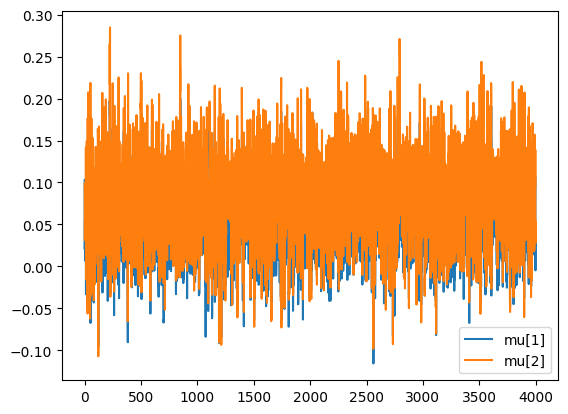

In [42]:
fit.draws_pd()[['mu[1]','mu[2]']].plot()

<Axes: >

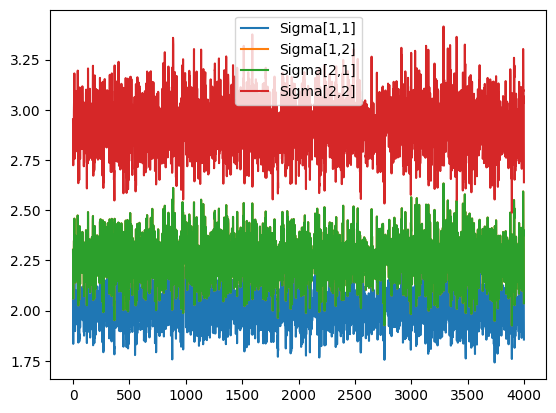

In [43]:
fit.draws_pd()[['Sigma[1,1]','Sigma[1,2]', 'Sigma[2,1]', 'Sigma[2,2]']].plot()

> Diagnostics all look good - R_hat close to 1 and fuzzy caterpillars!

In [44]:
# retrieve samples from prior PD
fit.draws_pd()['y_prior_pd'].hist()

KeyError: 'y_prior_pd'

3.

Simulate parameters from the posterior using `stan`. Describe how to treat diagnostics, and then interpret and display your results. Take note of any interesting findings regarding parameter estimates. 

Try to use [`hist2d()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html) to visualize the posteriof of $\mu$.
For visualizing the covariance matrix samples, just plot the three unique values on overlaid histograms.
                                                   

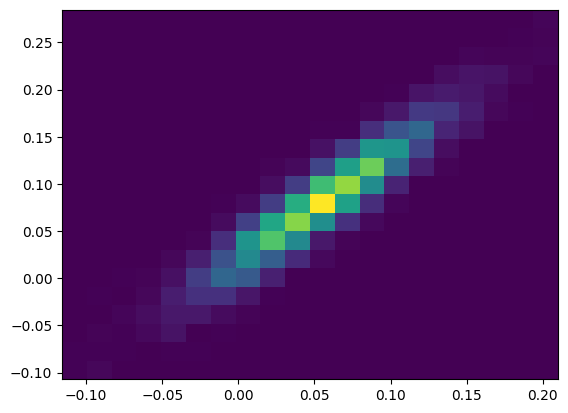

In [56]:
# samples from posterior
plt.hist2d(fit.draws_pd()['mu[1]'], fit.draws_pd()['mu[2]'], bins = 20)
plt.show()

> It looks like the variance is mostly in the direction of a positive linear relationship between the two.

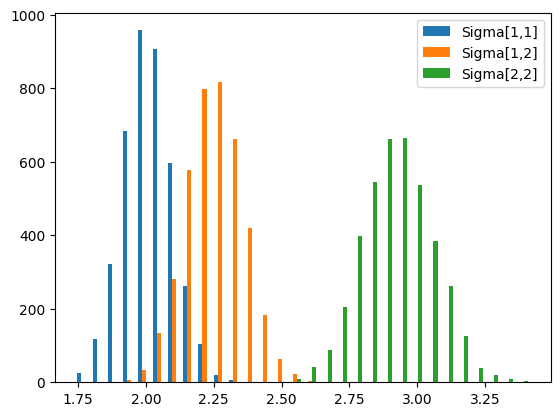

In [79]:
plt.hist(fit.draws_pd()[['Sigma[1,1]','Sigma[1,2]','Sigma[2,2]']],
         label = ['Sigma[1,1]','Sigma[1,2]','Sigma[2,2]'], 
         bins = 30)
plt.legend()
plt.show()

> Interestingly, it looks like both the stocks average positive. The covariance matrix would be about [[2, 2.2], [2.2, 2.8]], meaning that the second stock has a higher variance.

4.

Take your chosen portfolio weights from homework 4 and simulate portfolio returns from the posterior predictive distribution. Are they "good?" Visualize them in a variety of interesting ways!

How do these returns compare with "backtested" returns? In other words, how do these simulated returns compare with taking the same weight vector, and seeing how they did retrospectively on "real" (not simulated) data. 

Keep in mind that retrospective analysis is not always indicative of future results!

5.

Simulate parameters from the posterior after making adjustments to your prior. Do not feel obligated to re-do all of the same work you did in the previous problem. Instead, discuss (qualitatively) how sensitive your posterior appears to be to the choices you made on your prior. 

6.

Now choose any prior you want for the unknown mean and covariance matrix parameters. You can do anything you want as long as you

 - produce `stan` code that runs without error, and
 - use the LKJ distribution for the correlation matrix. 

Be sure to complete all the above steps:

 - simulate from the prior predictive distribution as a check on the prior;
 - simulate parameters from the posterior (check diagnostics, visualize and report); and
 - simulate from the posterior predictive distribution in the same way you did earlier.